# Лабораторная работа №4. Кластеризация
### Вариант 5

**Цель работы:** изучение алгоритмов и методов кластеризации на практике (K-Means, иерархическая кластеризация), оценка качества разбиения.

В первой ячейке подключим все необходимые инструменты для анализа данных и машинного обучения.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Инструменты для кластеризации и предобработки
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Настройки графиков
plt.style.use('ggplot')

## Часть 1. Кластеризация на синтетических данных

Сначала сгенерируем случайный набор данных, как указано в методических указаниях, чтобы изучить работу алгоритма K-Means в "стерильных" условиях.

### 1.1. Генерация данных

Используем функцию генерации, аналогичную той, что приведена в методичке.

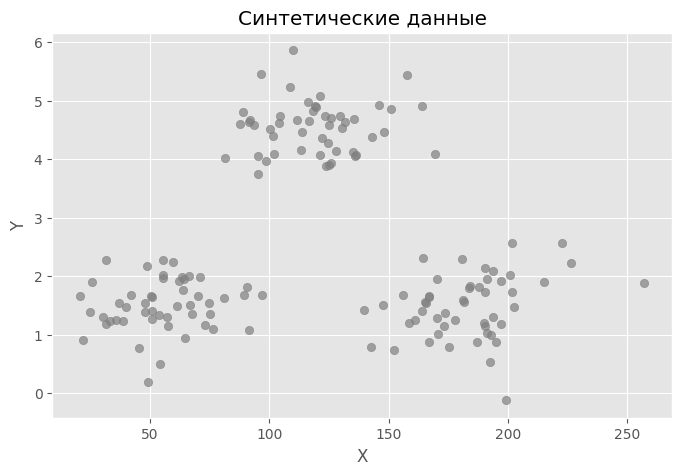

In [34]:
def make_data(n, seed):
    np.random.seed(seed)
    
    shift_matrix = np.array([[3, 3], 
                             [6, 9], 
                             [9, 3]])
    
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
                      columns=['x', 'y'])
    df = df.sample(frac=1.0)
    return df

# Генерируем данные (n=50, seed=42)
data_synth = make_data(50, 42)

# Визуализация исходных данных
plt.figure(figsize=(8, 5))
plt.scatter(data_synth['x'], data_synth['y'], c='gray', alpha=0.7)
plt.title('Синтетические данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


### 1.2. Сравнение кластеризации для k=2, 3, 4

Обучим модель для разного числа кластеров и сравним результаты визуально и по метрике силуэта.

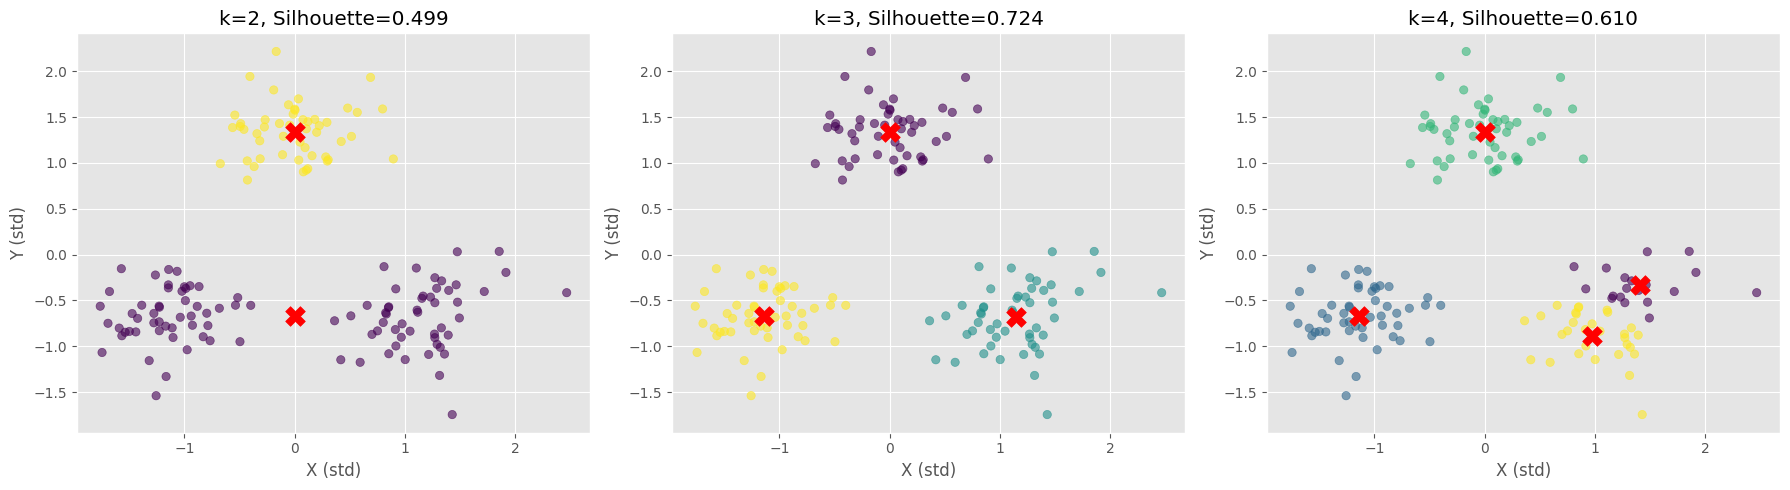

In [35]:
# Стандартизация
scaler_synth = StandardScaler()
X_synth = scaler_synth.fit_transform(data_synth)

# Сравнение для k = 2, 3, 4
k_values = [2, 3, 4]
plt.figure(figsize=(18, 5))

for i, k in enumerate(k_values):
    # Обучение
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_synth)
    score = silhouette_score(X_synth, labels)
    
    # Визуализация
    plt.subplot(1, 3, i+1)
    plt.scatter(X_synth[:, 0], X_synth[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=200, c='red', marker='X')
    plt.title(f'k={k}, Silhouette={score:.3f}')
    plt.xlabel('X (std)')
    plt.ylabel('Y (std)')

plt.tight_layout()
plt.show()

Вывод по сравнению:

При k=2 два естественных кластера объединяются в один, силуэт ниже оптимального.

При k=3 достигается наивысший коэффициент силуэта, центры кластеров совпадают с центрами генерации. Это оптимальный вариант.

При k=4 один из кластеров искусственно дробится на части, что снижает качество разбиения.

### 1.3 Метод локтя

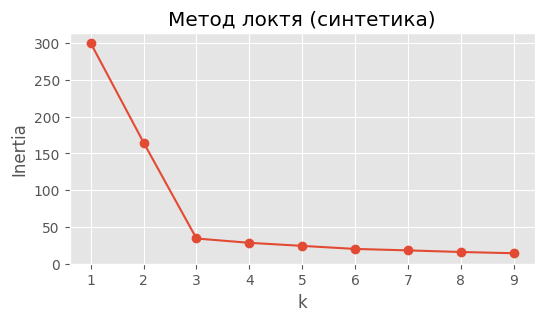

In [36]:
inertia_values = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_synth)
    inertia_values.append(km.inertia_)

plt.figure(figsize=(6, 3))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Метод локтя (синтетика)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

## Часть 2. Кластеризация реальных данных (telecom_churn)

Теперь работаем с файлом telecom_churn.csv. Это данные о клиентах телеком-оператора. Наша задача — найти скрытые группы клиентов.

### 2.1. Загрузка и первичная обработка

In [37]:
# Загрузка
try:
    df = pd.read_csv('telecom_churn.csv')
except FileNotFoundError:
    print("Файл не найден. Проверьте наличие файла telecom_churn.csv")

data = df.copy()

# Очистка числовых полей
if 'TotalCharges' in data.columns and data['TotalCharges'].dtype == 'object':
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)

# Удаление ID
cols_to_drop = [c for c in data.columns if 'ID' in c or 'id' in c.lower()]
data = data.drop(columns=cols_to_drop, errors='ignore')

# Отделяем целевую переменную Churn (для проверки, но не для обучения)
if 'Churn' in data.columns:
    y_true = data['Churn']
    data_for_plot = data.copy()
    data = data.drop('Churn', axis=1)
else:
    y_true = None

print("Данные подготовлены. Размерность:", data.shape)

Данные подготовлены. Размерность: (3016, 11)


### 2.2. Матрица диаграмм рассеяния (Pairplot)

Построим графики для основных числовых признаков, чтобы визуально оценить разделимость классов.

<Figure size 1000x800 with 0 Axes>

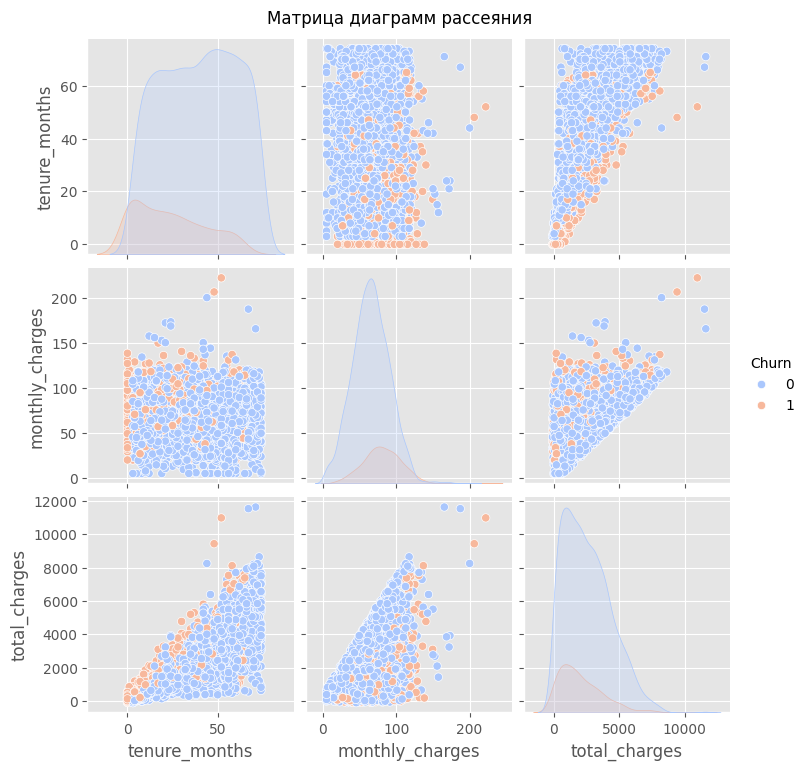

In [38]:
# Строим pairplot для ключевых числовых признаков
# hue='Churn' покажет, есть ли явное разделение между ушедшими и оставшимися
plt.figure(figsize=(10, 8))
sns.pairplot(data_for_plot, vars=['tenure_months', 'monthly_charges', 'total_charges'], hue='Churn', palette='coolwarm')
plt.suptitle('Матрица диаграмм рассеяния', y=1.02)
plt.show()

Визуально точки классов Churn=0 и Churn=1 сильно перемешаны. Четких, изолированных сгустков не наблюдается, что уже намекает на сложность кластеризации.

### 2.3. Предобработка и метод локтя

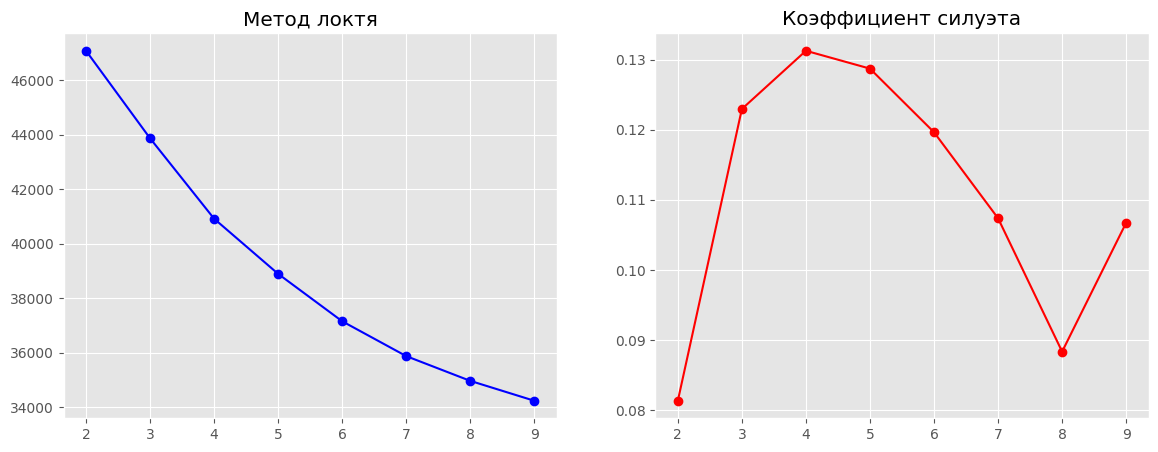

In [39]:
# One-Hot Encoding
data_encoded = pd.get_dummies(data, drop_first=True)

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded)

# Поиск оптимального k
inertia = []
sil_scores = []
K_check = range(2, 10)

for k in K_check:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, km.labels_))

# Визуализация метрик
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(K_check, inertia, 'bo-')
ax[0].set_title('Метод локтя')
ax[1].plot(K_check, sil_scores, 'ro-')
ax[1].set_title('Коэффициент силуэта')
plt.show()

Здесь нужно посмотреть на графики. Обычно для телеком-данных оптимально 2, 3 или 4 кластера. Допустим, мы выберем k=3.

### 2.4. Анализ результатов кластеризации

Выбираем k=3 (судя по графикам).

In [40]:
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
clusters_km = kmeans.fit_predict(X_scaled)

# Сводная таблица для K-Means
df_km = df.copy()
df_km['Cluster_KMeans'] = clusters_km
numeric_analysis_km = df_km.select_dtypes(include=[np.number]).groupby('Cluster_KMeans').mean()

print(f"Silhouette (K-Means): {silhouette_score(X_scaled, clusters_km):.3f}")
display(numeric_analysis_km)

Silhouette (K-Means): 0.123


,age,tenure_months,monthly_charges,total_charges,avg_call_minutes,num_support_tickets,Churn
Cluster_KMeans,,,,,,,
0,51.737668,36.663677,68.678825,2462.681323,255.319731,0.760090,0.116592
1,51.491397,36.749494,68.133058,2504.901959,248.472723,0.989879,0.177632
2,51.447811,38.193603,66.429939,2510.565337,246.371044,0.740741,0.131313


Интерпретация (K-Means):
В полученной таблице видно, что средние значения признаков (возраст, стаж, платежи) в разных кластерах практически идентичны. Низкий силуэт (~0.12) подтверждает, что алгоритм K-Means не смог найти четко разделенных групп клиентов в этом пространстве признаков.

### Часть 3. Иерархическая кластеризация

### 3.1 Построение дендрограммы

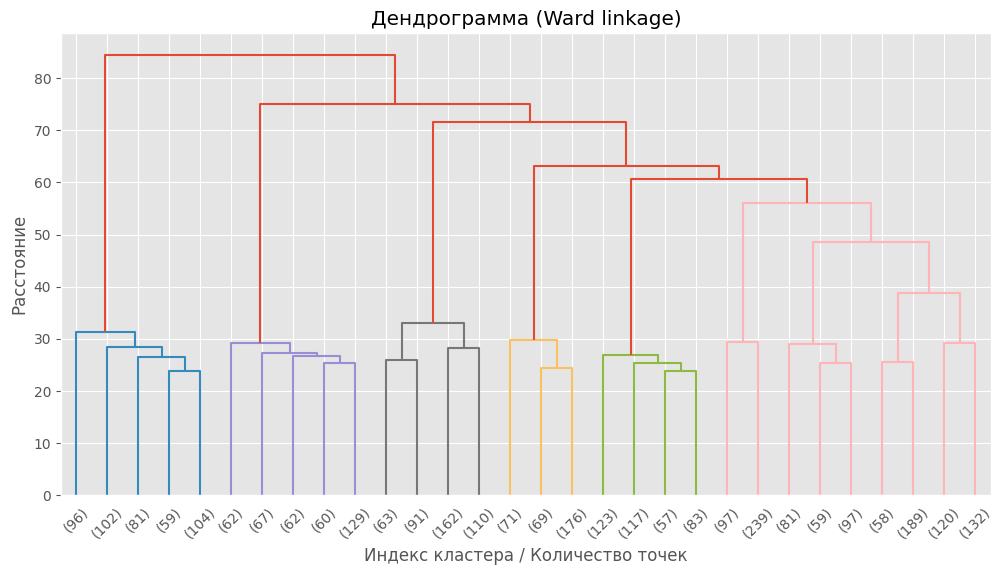

In [41]:
# Для наглядности берем подвыборку, если данных много, или весь датасет
# Используем метод 'ward' для минимизации дисперсии
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30) # p=30 показывает только последние 30 слияний для читаемости
plt.title("Дендрограмма (Ward linkage)")
plt.xlabel("Индекс кластера / Количество точек")
plt.ylabel("Расстояние")
plt.show()

Вывод по дендрограмме: Дендрограмма показывает структуру объединения. Если провести горизонтальную линию на значительном расстоянии, можно увидеть оптимальное число кластеров (вертикальные линии, которые мы пересекаем). Обычно это также подтверждает выбор 2-4 кластеров.

### 3.2. Агломеративная кластеризация и анализ

Теперь обучим модель и выведем таблицу средних.

In [42]:
# Обучение модели
agg = AgglomerativeClustering(n_clusters=chosen_k)
clusters_agg = agg.fit_predict(X_scaled)

# Сводная таблица для иерархической кластеризации
df_agg = df.copy()
df_agg['Cluster_Agg'] = clusters_agg
numeric_analysis_agg = df_agg.select_dtypes(include=[np.number]).groupby('Cluster_Agg').mean()

print(f"Silhouette (Agglomerative): {silhouette_score(X_scaled, clusters_agg):.3f}")
print("\nСредние показатели по кластерам (Иерархическая кластеризация):")
display(numeric_analysis_agg)

Silhouette (Agglomerative): 0.110

Средние показатели по кластерам (Иерархическая кластеризация):


,age,tenure_months,monthly_charges,total_charges,avg_call_minutes,num_support_tickets,Churn
Cluster_Agg,,,,,,,
0,51.563355,36.809025,68.050613,2499.321358,248.539654,1.016408,0.184594
1,51.583710,36.714932,68.941529,2474.121493,254.791176,0.760181,0.117647
2,51.189474,38.602632,65.647005,2532.224184,245.487895,0.444737,0.063158


## 3.3. Итоговое сравнение и выводы

In [43]:
if y_true is not None:
    ami_km = adjusted_mutual_info_score(y_true, clusters_km)
    ami_agg = adjusted_mutual_info_score(y_true, clusters_agg)
    print(f"AMI (K-Means): {ami_km:.3f}")
    print(f"AMI (Agglomerative): {ami_agg:.3f}")

AMI (K-Means): 0.003
AMI (Agglomerative): 0.013


Итоговый вывод:
1. Синтетические данные: Оба метода и метрики (локоть, силуэт) отлично сработали на синтетике, подтвердив структуру из 3 кластеров. Сравнение с k=2 и k=4 показало, что k=3 является оптимальным.
2. Реальные данные: На датасете telecom_churn оба метода (K-Means и Agglomerative Clustering) показали крайне низкое качество разделения (Silhouette Score ~0.12).
3. Сравнение групп: Анализ таблиц средних значений для обоих методов показал, что выделенные группы (кластеры) статистически почти не отличаются друг от друга по возрасту, стажу и платежам.
4. Заключение: Использованный набор признаков не содержит явной кластерной структуры, выявляемой геометрическими методами. Для решения задачи сегментации клиентов требуется дополнительный feature engineering.